In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import rasterio

from tqdm import tqdm

from PIL import Image

import os
import glob

from matplotlib import pyplot as plt

In [55]:
data_directory = '/workspace/Data_share/'
tif_files = glob.glob(os.path.join(data_directory, '**', '*.tif'), recursive=True)
print(len(tif_files))

6012


In [52]:
ca_files = glob.glob(os.path.join('/workspace/Data_share/Data_share/CA', '**', '*.tif'), recursive=True)
il_files = glob.glob(os.path.join('/workspace/Data_share/Data_share/IL', '**', '*.tif'), recursive=True)
nd_files = glob.glob(os.path.join('/workspace/Data_share/Data_share/ND', '**', '*.tif'), recursive=True)
ne_files = glob.glob(os.path.join('/workspace/Data_share/Data_share/NE', '**', '*.tif'), recursive=True)

## Get Statistics for all sub-directories

In [53]:
class ImageData(Dataset):
    
    def __init__(self, file_paths):
        super().__init__()
        self.file_paths = file_paths
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        
        # import
        file_path = self.file_paths[idx]        
        with rasterio.open(file_path, mode='r') as src:
            data = src.read().astype('float32')

        return data


In [54]:
for state, files in {'ND': nd_files}.items():
    image_dataset = ImageData(files)
    image_loader = DataLoader(image_dataset, 
                          batch_size  = 1, 
                          shuffle     = False, 
                          num_workers = 0)
    psum    = torch.tensor([0.0])
    psum_sq = torch.tensor([0.0])
    avg_elevation = []
    min_elevation = []
    max_elevation = []
    elevation_range = []
    
    # loop through images
    for inputs in tqdm(image_loader):
        if inputs.max() > 100000 or inputs.min() < 0:
            continue
        psum += inputs.sum()
        psum_sq += (inputs ** 2).sum()
    
        avg_elevation.append(inputs.mean())
        min_elevation.append(inputs.mean())
        max_elevation.append(inputs.max())
        elevation_range.append(inputs.max() - inputs.min())
        
    # pixel count
    count = len(tif_files) * 800 * 800
    
    # mean and STD
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)
    
    avg_elevation = torch.stack(avg_elevation, dim=0)
    min_elevation = torch.stack(min_elevation, dim=0)
    max_elevation = torch.stack(max_elevation, dim=0)
    elevation_range = torch.stack(elevation_range, dim=0)
    
    # output
    print(f'Training data stats for {state}:')
    print('- mean: {:.4f}'.format(total_mean.item()))
    print('- std:  {:.4f}'.format(total_std.item()))
    print('- maximum average elevation: {:.4f}'.format(avg_elevation.max().item()))
    print('- highest maximum elevation: {:.4f}'.format(max_elevation.max().item()))
    print('- average elevation change: {:.4f}'.format(elevation_range.mean().item()))
    


100%|█████████████████████████████████████████| 612/612 [00:16<00:00, 37.58it/s]

Training data stats for ND:
- mean: 36.0803
- std:  108.9932
- maximum average elevation: 463.3238
- highest maximum elevation: 470.6870
- average elevation change: 12.5549


## Convert all elevation into relative elevation

In [56]:
for tif_file in tqdm(nd_files, total=len(tif_files)):
    with rasterio.open(tif_file, 'r') as src:
        kwrds = src.profile
        data = src.read(1)

        min_value = data.min()
        
        # subtract minimum value from the raster
        new_data = data - min_value

    kwrds.update(
        dtype=rasterio.float32,
        nodata=None
    )
    
    with rasterio.open(tif_file, 'w', **kwrds) as dst:
        dst.write(new_data, 1)


 10%|████                                    | 612/6012 [00:40<05:55, 15.20it/s]


## Get mean and standard deviation for all chosen image chips

In [57]:
all_chips = nd_files
image_dataset = ImageData(all_chips)
image_loader = DataLoader(image_dataset, 
                      batch_size  = 1, 
                      shuffle     = False, 
                      num_workers = 0)

psum    = torch.tensor([0.0])
psum_sq = torch.tensor([0.0])
avg_elevation = []
min_elevation = []
max_elevation = []
elevation_range = []

# loop through images
for inputs in tqdm(image_loader):
    if inputs.max() > 100000 or inputs.min() < 0:
        continue
    psum += inputs.sum()
    psum_sq += (inputs ** 2).sum()

    avg_elevation.append(inputs.mean())
    min_elevation.append(inputs.mean())
    max_elevation.append(inputs.max())
    elevation_range.append(inputs.max() - inputs.min())
    
# pixel count
count = len(tif_files) * 800 * 800

# mean and STD
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('Training data stats:')
print('- mean: {:.4f}'.format(total_mean.item()))
print('- std:  {:.4f}'.format(total_std.item()))

avg_elevation = torch.stack(avg_elevation, dim=0)
min_elevation = torch.stack(min_elevation, dim=0)
max_elevation = torch.stack(max_elevation, dim=0)
elevation_range = torch.stack(elevation_range, dim=0)

100%|█████████████████████████████████████████| 612/612 [00:12<00:00, 49.17it/s]

Training data stats:
- mean: 0.7294
- std:  9.3929


Text(0.5, 0, 'Bins')

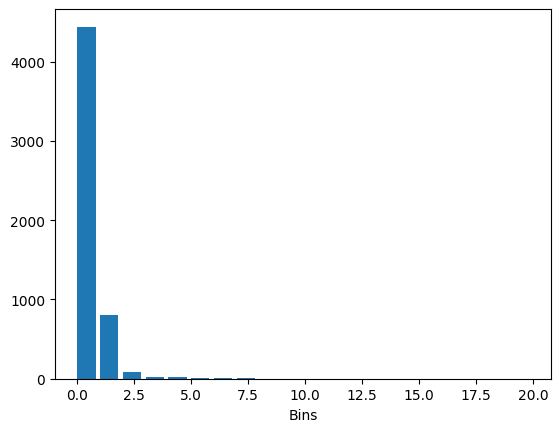

In [50]:
hist = torch.histc(avg_elevation, bins = 20, min = 0, max = avg_elevation.max())

bins = 20
x = range(bins)
plt.bar(x, hist, align='edge')
plt.xlabel('Bins')
